Name:   
Matrikelnummer:  
Email:   
   
Name:   
Matrikelnummer:   
Email:

Name:    
Matrikelnummer:    
Email:    

#### Preamble

In [91]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt

from tqdm import tqdm

# 7.5 Build your own regularized NN

In this exercise you get to use your previously built networks, but this time you need to add regularization in the form of dropout and $L_2$-regularization.

Each layer has the option of using dropout. Your code needs to allow for this flexibility.

Additionally, adding $L_2$-regularization should also be optional upon creation.

**NOTE**: You are allowed to use built-in functions from pytorch to incorporate this functionality.

### 7.5.1 Implement a regularized model (1 point)

Implement your own model (using `torch`) using the skeleton code provided.

In [92]:
def f1_loss(y_true:torch.Tensor, y_pred:torch.Tensor, is_training=False) -> torch.Tensor:
    assert y_true.ndim == 1
    assert y_pred.ndim == 1 or y_pred.ndim == 2

    if y_pred.ndim == 2:
        y_pred = y_pred.argmax(dim=1)


    tp = (y_true * y_pred).sum().to(torch.float32)
    tn = ((1 - y_true) * (1 - y_pred)).sum().to(torch.float32)
    fp = ((1 - y_true) * y_pred).sum().to(torch.float32)
    fn = (y_true * (1 - y_pred)).sum().to(torch.float32)

    epsilon = 1e-7

    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)

    f1 = 2* (precision*recall) / (precision + recall + epsilon)
    f1.requires_grad = is_training
    return f1

In [102]:
class Model(nn.Module):
    """
    Implement a model that incorporates dropout and L2 regularization
    depending on arguments passed.
    
    Args:
    input_dim: dimensionality of the inputs
    hidden_dim: how many units each hidden layer will have
    out_dim: how many output units
    num_layers: how many hidden layers to create/use
    dropout: a list of booleans specifying which hidden layers will have dropout
    dropout_p: the probability used for the `Dropout` layers
    l2_reg: a boolean value that indicates whether L2 regularization should be used
    """
    def __init__(self,
                 input_dim: int,
                 hidden_dim: int,
                 out_dim: int,
                 num_layers: int,
                 dropout: list,
                 dropout_p: float,
                 l2_reg: bool):
        super().__init__()

        self.l2_reg = l2_reg

        layers = []

        layers.append(nn.Flatten())
        layers.append(nn.Linear(input_dim, hidden_dim, bias=True))
        layers.append(nn.ReLU())

        if dropout[0]:
            layers.append(nn.Dropout(dropout_p))

        for i in range(num_layers-1):
            layers.append(nn.Linear(hidden_dim, hidden_dim, bias=True))
            layers.append(nn.ReLU())
            if dropout[i+1]:
                layers.append(nn.Dropout(dropout_p))

        layers.append(nn.Linear(hidden_dim, out_dim))

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return F.softmax(self.layers.forward(x), dim=1)

    def fit(self, train_loader, test_loader, epochs=1, lr=1e-4, alpha=1e-5):
        # define optimizer
        sgd = None
        if self.l2_reg:
            sgd = torch.optim.Adam(lr=lr, params=self.parameters(), weight_decay=alpha)
        else:
            sgd = torch.optim.Adam(lr=lr, params=self.parameters())

        criterion = nn.CrossEntropyLoss()

        train_f1s = []
        train_accuracys = []

        test_accuracys = []
        test_f1s = []

        for epoch in range(epochs):
            print('epoch:', epoch)
            # print("#" * 50, "epoch:", epoch, "#"*50)
            train_f1 = None
            train_accuracy = None

            test_accuracy = None
            test_f1 = None

            train_loss = torch.tensor(0.0)
            test_loss = torch.tensor(0.0)

            i = 0

            # train
            # print('training...')
            targets = []
            predictions = []
            for i, (x, y) in tqdm(enumerate(train_loader), total=len(train_loader)):
                sgd.zero_grad()

                # forward pass
                pred = self.forward(x)

                # optimizer stuff
                loss = criterion(pred, y)
                loss.backward()

                train_loss += loss
                sgd.step()

                _, p = torch.max(pred, 1)
                # accuracy/f1
                for i in range(pred.shape[0]):
                    targets.append(y[i])
                    predictions.append(p[i])

            train_loss /= len(train_loader)
            # print('train loss:', train_loss.item())

            targets = torch.tensor(targets)
            predictions = torch.tensor(predictions)

            # accuracy
            train_accuracy = torch.sum(targets == predictions) / targets.shape[0]
            train_f1 = f1_loss(targets, predictions)


            # print('testing...')
            with torch.no_grad():
                targets = []
                outputs = []

                for i, (x, y) in tqdm(enumerate(test_loader), total=len(test_loader)):
                    pred = self.forward(x)
                    loss = criterion(pred, y)

                    test_loss += loss

                    for i in range(pred.shape[0]):
                        _, predicted = torch.max(pred[i], 0)
                        outputs.append(predicted)
                        targets.append(y[i])

                outputs = torch.tensor(outputs)
                targets = torch.tensor(targets)

                test_f1 = f1_loss(targets, outputs)
                test_accuracy = torch.sum(targets == outputs) / targets.shape[0]

                test_loss /= len(test_loader)
                # print('train loss:', test_loss.item())

            print(
                'F1:', f'train: {train_f1:.3g}', f'test: {test_f1:.3g}'
            )
            print(
                'Accuracy:', f'train: {train_accuracy:.3g}', f'test: {test_accuracy:.3g}'
            )
            print(
                'Loss:', f'train: {train_loss:.3g}', f'test: {test_loss:.3g}'
            )

            train_f1s.append(train_f1)
            test_f1s.append(test_f1)

            train_accuracys.append(train_accuracy)
            test_accuracys.append(test_accuracy)

        return train_f1s, test_f1s, train_accuracys, test_accuracys

### 7.5.2 Experiment with your model (1 point)

Use the MNIST dataset and evaluation code from the previous assignment to run some experiments. Run the following experiments:

1. Shallow network (not more than 1 hidden layer)
1. Shallow regularized network
1. Deep network (at least 3 hidden layers)
1. Deep regularized network

Report Accuracy and $F_1$ metrics for your experiments and discuss your results. What did you expect to see and what did you end up seeing.

**NOTE**: You can choose how you use regularization. Ideally you would experiment with various parameters for this regularization, the 4 listed variants are merely what you must cover as a minimum. Report results for all your experiments concisely in a table.

**NOTE 2**: Make sure to report your metrics on the training and evaluation/heldout sets.

In [103]:
# Load the data
# DO NOT CHANGE THE CODE IN THIS CELL EXCEPT FOR THE BATCH SIZE IF NECESSARY
transform_fn = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.7,), (0.7,)),])

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform_fn)
train_dl = torch.utils.data.DataLoader(mnist_train, batch_size=32, shuffle=True)

mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform_fn)
test_dl = torch.utils.data.DataLoader(mnist_test, batch_size=32, shuffle=False)

# Use the above data for your experiments

In [108]:
model = Model(
    input_dim=28*28,
    hidden_dim=512,
    out_dim=10,
    num_layers=4,
    dropout=[True, True, True, False],
    dropout_p=0.5,
    l2_reg=False
)


f1_train_deep_reg, f1_test_deep_reg,train_acc_deep_reg, test_acc_deep_reg = model.fit(train_dl, test_dl, epochs=10)

epoch: 0


100%|██████████| 313/313 [00:05<00:00, 61.41it/s]


F1: train: 5.5 test: 6.12
Accuracy: train: 0.615 test: 0.789
Loss: train: 1.85 test: 1.68
epoch: 1


100%|██████████| 313/313 [00:05<00:00, 62.57it/s]


F1: train: 6.06 test: 6.12
Accuracy: train: 0.846 test: 0.878
Loss: train: 1.62 test: 1.59
epoch: 2


100%|██████████| 313/313 [00:04<00:00, 63.20it/s]


F1: train: 6.1 test: 6.15
Accuracy: train: 0.875 test: 0.886
Loss: train: 1.59 test: 1.58
epoch: 3


100%|██████████| 313/313 [00:05<00:00, 62.04it/s]


F1: train: 6.11 test: 6.07
Accuracy: train: 0.888 test: 0.895
Loss: train: 1.57 test: 1.57
epoch: 4


100%|██████████| 313/313 [00:05<00:00, 59.55it/s]


F1: train: 6.13 test: 6.14
Accuracy: train: 0.899 test: 0.909
Loss: train: 1.56 test: 1.55
epoch: 5


100%|██████████| 313/313 [00:05<00:00, 62.56it/s]


F1: train: 6.14 test: 6.14
Accuracy: train: 0.903 test: 0.902
Loss: train: 1.56 test: 1.56
epoch: 6


100%|██████████| 313/313 [00:05<00:00, 60.78it/s]


F1: train: 6.15 test: 6.2
Accuracy: train: 0.908 test: 0.91
Loss: train: 1.55 test: 1.55
epoch: 7


100%|██████████| 313/313 [00:05<00:00, 62.09it/s]


F1: train: 6.14 test: 6.17
Accuracy: train: 0.909 test: 0.904
Loss: train: 1.55 test: 1.56
epoch: 8


100%|██████████| 313/313 [00:05<00:00, 61.40it/s]


F1: train: 6.16 test: 6.21
Accuracy: train: 0.914 test: 0.919
Loss: train: 1.55 test: 1.54
epoch: 9


100%|██████████| 313/313 [00:04<00:00, 62.70it/s]


F1: train: 6.17 test: 6.16
Accuracy: train: 0.916 test: 0.92
Loss: train: 1.55 test: 1.54


In [109]:
model = Model(
    input_dim=28*28,
    hidden_dim=512,
    out_dim=10,
    num_layers=4,
    dropout=[False, False, False, False],
    dropout_p=0.5,
    l2_reg=False
)


f1_train_deep, f1_test_deep, train_acc_deep, test_acc_deep = model.fit(train_dl, test_dl, epochs=10)

epoch: 0


100%|██████████| 313/313 [00:05<00:00, 62.35it/s]


F1: train: 5.96 test: 6.22
Accuracy: train: 0.758 test: 0.838
Loss: train: 1.72 test: 1.63
epoch: 1


100%|██████████| 313/313 [00:04<00:00, 63.85it/s]


F1: train: 6.14 test: 6.18
Accuracy: train: 0.871 test: 0.918
Loss: train: 1.59 test: 1.55
epoch: 2


100%|██████████| 313/313 [00:05<00:00, 62.44it/s]


F1: train: 6.16 test: 6.17
Accuracy: train: 0.919 test: 0.928
Loss: train: 1.55 test: 1.53
epoch: 3


100%|██████████| 313/313 [00:05<00:00, 60.76it/s]


F1: train: 6.2 test: 6.16
Accuracy: train: 0.934 test: 0.938
Loss: train: 1.53 test: 1.52
epoch: 4


100%|██████████| 313/313 [00:04<00:00, 65.29it/s]


F1: train: 6.21 test: 6.21
Accuracy: train: 0.942 test: 0.935
Loss: train: 1.52 test: 1.53
epoch: 5


100%|██████████| 313/313 [00:04<00:00, 65.08it/s]


F1: train: 6.22 test: 6.17
Accuracy: train: 0.948 test: 0.947
Loss: train: 1.51 test: 1.51
epoch: 6


100%|██████████| 313/313 [00:04<00:00, 66.28it/s]


F1: train: 6.23 test: 6.2
Accuracy: train: 0.953 test: 0.954
Loss: train: 1.51 test: 1.51
epoch: 7


100%|██████████| 313/313 [00:04<00:00, 67.16it/s]


F1: train: 6.23 test: 6.25
Accuracy: train: 0.956 test: 0.954
Loss: train: 1.51 test: 1.51
epoch: 8


100%|██████████| 313/313 [00:05<00:00, 60.21it/s]


F1: train: 6.24 test: 6.18
Accuracy: train: 0.959 test: 0.946
Loss: train: 1.5 test: 1.52
epoch: 9


100%|██████████| 313/313 [00:05<00:00, 62.36it/s]

F1: train: 6.24 test: 6.25
Accuracy: train: 0.96 test: 0.959
Loss: train: 1.5 test: 1.5


In [106]:
model = Model(
    input_dim=28*28,
    hidden_dim=420,
    out_dim=10,
    num_layers=1,
    dropout=[False, False, False, False],
    dropout_p=0.7,
    l2_reg=False
)


f1_train, f1_test, train_acc, test_acc = model.fit(train_dl, test_dl, epochs=7)

epoch: 0


100%|██████████| 313/313 [00:05<00:00, 56.80it/s]


F1: train: 5.86 test: 6.13
Accuracy: train: 0.764 test: 0.885
Loss: train: 1.75 test: 1.61
epoch: 1


100%|██████████| 313/313 [00:03<00:00, 78.51it/s]


F1: train: 6.13 test: 6.11
Accuracy: train: 0.897 test: 0.908
Loss: train: 1.59 test: 1.57
epoch: 2


100%|██████████| 313/313 [00:04<00:00, 67.98it/s]


F1: train: 6.15 test: 6.19
Accuracy: train: 0.908 test: 0.913
Loss: train: 1.57 test: 1.56
epoch: 3


100%|██████████| 313/313 [00:04<00:00, 77.44it/s]


F1: train: 6.16 test: 6.13
Accuracy: train: 0.915 test: 0.921
Loss: train: 1.56 test: 1.55
epoch: 4


100%|██████████| 313/313 [00:04<00:00, 76.11it/s]


F1: train: 6.17 test: 6.17
Accuracy: train: 0.921 test: 0.925
Loss: train: 1.55 test: 1.54
epoch: 5


100%|██████████| 313/313 [00:04<00:00, 74.13it/s]


F1: train: 6.18 test: 6.19
Accuracy: train: 0.927 test: 0.931
Loss: train: 1.54 test: 1.54
epoch: 6


100%|██████████| 313/313 [00:04<00:00, 66.99it/s]

F1: train: 6.19 test: 6.21
Accuracy: train: 0.931 test: 0.934
Loss: train: 1.54 test: 1.53


In [107]:
model = Model(
    input_dim=28*28,
    hidden_dim=420,
    out_dim=10,
    num_layers=1,
    dropout=[True, True, True, False],
    dropout_p=0.7,
    l2_reg=False
)


f1_train_shallow_reg, f1_test_shallow_reg, train_acc_shallow_reg, test_acc_shallow_reg = model.fit(train_dl, test_dl, epochs=10)

epoch: 0


100%|██████████| 313/313 [00:04<00:00, 71.57it/s]


F1: train: 5.7 test: 5.99
Accuracy: train: 0.689 test: 0.793
Loss: train: 1.83 test: 1.7
epoch: 1


100%|██████████| 313/313 [00:05<00:00, 59.87it/s]


F1: train: 6.03 test: 6.09
Accuracy: train: 0.832 test: 0.867
Loss: train: 1.66 test: 1.62
epoch: 2


100%|██████████| 313/313 [00:04<00:00, 77.44it/s]


F1: train: 6.07 test: 6.11
Accuracy: train: 0.87 test: 0.886
Loss: train: 1.61 test: 1.6
epoch: 3


100%|██████████| 313/313 [00:04<00:00, 76.85it/s]


F1: train: 6.1 test: 6.08
Accuracy: train: 0.883 test: 0.891
Loss: train: 1.6 test: 1.58
epoch: 4


100%|██████████| 313/313 [00:04<00:00, 72.03it/s]


F1: train: 6.11 test: 6.18
Accuracy: train: 0.891 test: 0.903
Loss: train: 1.59 test: 1.57
epoch: 5


100%|██████████| 313/313 [00:04<00:00, 74.55it/s]


F1: train: 6.13 test: 6.16
Accuracy: train: 0.898 test: 0.901
Loss: train: 1.58 test: 1.57
epoch: 6


100%|██████████| 313/313 [00:04<00:00, 76.59it/s]


F1: train: 6.13 test: 6.16
Accuracy: train: 0.904 test: 0.91
Loss: train: 1.57 test: 1.56
epoch: 7


100%|██████████| 313/313 [00:04<00:00, 73.86it/s]


F1: train: 6.15 test: 6.18
Accuracy: train: 0.909 test: 0.912
Loss: train: 1.56 test: 1.56
epoch: 8


100%|██████████| 313/313 [00:04<00:00, 71.32it/s]


F1: train: 6.16 test: 6.15
Accuracy: train: 0.913 test: 0.915
Loss: train: 1.56 test: 1.55
epoch: 9


100%|██████████| 313/313 [00:04<00:00, 74.34it/s]


F1: train: 6.16 test: 6.16
Accuracy: train: 0.915 test: 0.92
Loss: train: 1.56 test: 1.55


Text(0.5, 1.0, 'F1 test')

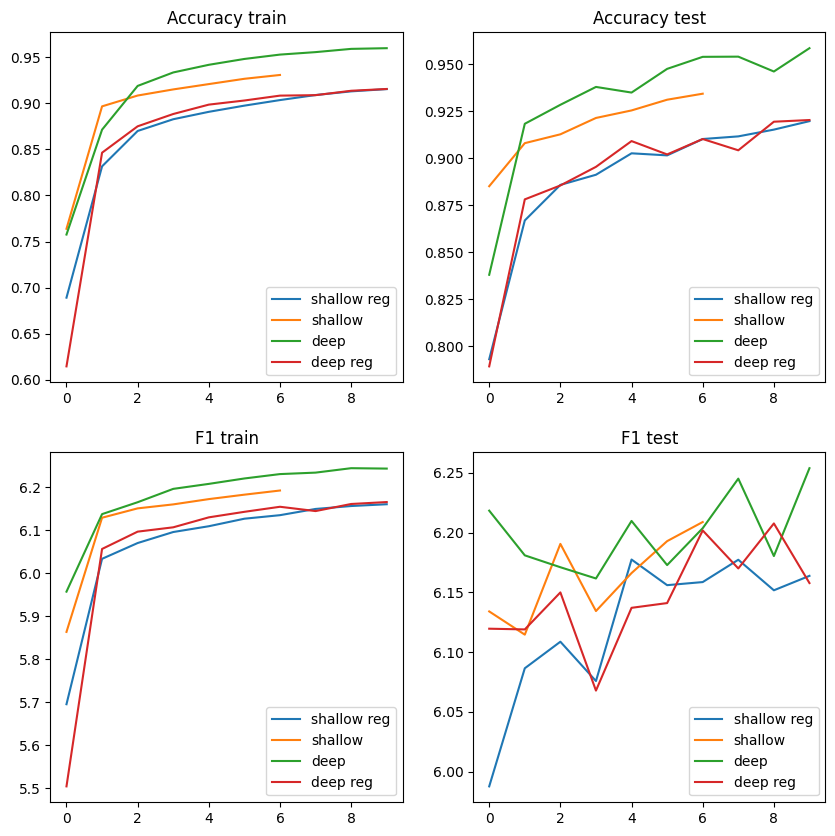

In [116]:
# plot
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

# accuracy
ax[0][0].plot(train_acc_shallow_reg, label='shallow reg')
ax[0][0].plot(train_acc, label='shallow')
ax[0][0].plot(train_acc_deep, label='deep')
ax[0][0].plot(train_acc_deep_reg, label='deep reg')
ax[0][0].legend()
ax[0][0].set_title('Accuracy train')
# train
ax[0][1].plot(test_acc_shallow_reg, label='shallow reg')
ax[0][1].plot(test_acc, label='shallow')
ax[0][1].plot(test_acc_deep, label='deep')
ax[0][1].plot(test_acc_deep_reg, label='deep reg')
ax[0][1].legend()
ax[0][1].set_title('Accuracy test')

# f1
ax[1][0].plot(f1_train_shallow_reg, label='shallow reg')
ax[1][0].plot(f1_train, label='shallow')
ax[1][0].plot(f1_train_deep, label='deep')
ax[1][0].plot(f1_train_deep_reg, label='deep reg')
ax[1][0].legend()
ax[1][0].set_title('F1 train')
# train
ax[1][1].plot(f1_test_shallow_reg, label='shallow reg')
ax[1][1].plot(f1_test, label='shallow')
ax[1][1].plot(f1_test_deep, label='deep')
ax[1][1].plot(f1_test_deep_reg, label='deep reg')
ax[1][1].legend()
ax[1][1].set_title('F1 test')

While we expected the accuracies to the regularized models to have worse training accuracies than the non-regularized, we are surprised that the regularization did not improve (it even worsen) the test accuracies.

We kept our hyperparameter the same for all models, in order to removed unwanted biases

### 7.5.3 Get the best model! (1 + 1 point (bonus))

* Present your model during a tutorial session. Justify your decisions when designing your model/solution.
* If you achieve one of the top N results, you get yet another extra point!

In [119]:
# the deep model is the best
model = Model(
    input_dim=28*28,
    hidden_dim=512,
    out_dim=10,
    num_layers=5,
    dropout=[False, False, True, False, False],
    dropout_p=0.5,
    l2_reg=True
)


f1_train_shallow_reg, f1_test_shallow_reg, train_acc_shallow_reg, test_acc_shallow_reg = model.fit(train_dl, test_dl, epochs=10)

epoch: 0


100%|██████████| 313/313 [00:05<00:00, 61.80it/s]


F1: train: 5.84 test: 6.08
Accuracy: train: 0.73 test: 0.876
Loss: train: 1.74 test: 1.59
epoch: 1


100%|██████████| 313/313 [00:05<00:00, 56.86it/s]


F1: train: 6.12 test: 6.13
Accuracy: train: 0.886 test: 0.903
Loss: train: 1.58 test: 1.56
epoch: 2


100%|██████████| 313/313 [00:05<00:00, 59.27it/s]


F1: train: 6.15 test: 6.22
Accuracy: train: 0.914 test: 0.921
Loss: train: 1.55 test: 1.54
epoch: 3


100%|██████████| 313/313 [00:06<00:00, 46.83it/s]


F1: train: 6.17 test: 6.17
Accuracy: train: 0.926 test: 0.937
Loss: train: 1.54 test: 1.52
epoch: 4


100%|██████████| 313/313 [00:05<00:00, 56.69it/s]


F1: train: 6.19 test: 6.23
Accuracy: train: 0.936 test: 0.944
Loss: train: 1.53 test: 1.52
epoch: 5


100%|██████████| 313/313 [00:05<00:00, 54.98it/s]


F1: train: 6.21 test: 6.21
Accuracy: train: 0.94 test: 0.935
Loss: train: 1.52 test: 1.53
epoch: 6


100%|██████████| 313/313 [00:06<00:00, 47.97it/s]


F1: train: 6.21 test: 6.21
Accuracy: train: 0.944 test: 0.951
Loss: train: 1.52 test: 1.51
epoch: 7


100%|██████████| 313/313 [00:05<00:00, 56.16it/s]


F1: train: 6.22 test: 6.25
Accuracy: train: 0.948 test: 0.948
Loss: train: 1.51 test: 1.51
epoch: 8


100%|██████████| 313/313 [00:05<00:00, 56.67it/s]


F1: train: 6.22 test: 6.19
Accuracy: train: 0.951 test: 0.953
Loss: train: 1.51 test: 1.51
epoch: 9


100%|██████████| 313/313 [00:05<00:00, 55.63it/s]


F1: train: 6.23 test: 6.11
Accuracy: train: 0.952 test: 0.934
Loss: train: 1.51 test: 1.53
